# 미니 경진대회 - 배터리 수명 예측

본 파일은 경연대회에 참가하시는 모든 참가자 분들에게 제공되는 기본 코드입니다. 따라서 **본인이 원하는 대로 자유롭게 수정하면서 경진대회를 진행하세요.** 

본 코드는 플랫폼 상에서 데이터를 불러오는 방법부터 간단한 전처리 및 머신러닝 모델링 과정을 소개하고 있습니다. 나아가서 작성한 코드의 결과를 플랫폼 상에서 바로 채점하기 위한 과정까지 확인해볼 수 있습니다.

In [ ]:
# 만약 라이브러리를 설치하는 명령어가 있다면, 이 셀에 몰아두는 것을 권장합니다.


In [1]:
# 예시 코드에 필요한 라이브러리를 불러옵니다.
import os

import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVR


data_dir = "/mnt/elice/dataset"

## 데이터 불러오기

학습 데이터와 테스트 데이터를 불러옵니다.

In [2]:
train_df = pd.read_csv(os.path.join(data_dir, "train_data.csv"), index_col="Cell_ID")
test_df = pd.read_csv(os.path.join(data_dir, "test_data.csv"), index_col="Cell_ID")

# 테스트 데이터도 학습용 데이터와 같이 'Lifetime' 컬럼이 있지만 값은 비어 있습니다.
# Lifetime 컬럼을 제거해 줍니다.
test_x = test_df.drop(["Lifetime"], axis=1)
train_x = train_df.iloc[:, :-1]
train_y = train_df.iloc[:, -1]

불러온 학습 데이터의 일부를 확인해봅시다.

In [10]:
# 학습 데이터 컬럼의 종류를 확인했습니다.
train_df.columns

Index(['CV_time_0', 'CV_time_3', 'Chg_C-rate', 'Dchg_C-rate', 'DoD', 'Q_ini',
       'Q_ini_V_high', 'Q_ini_V_low', 'Q_ini_V_mid', 'Q_initial', 'avg_stress',
       'capacity_fade_3_0', 'chg_stress', 'dchg_stress', 'delta_CV_time_3_0',
       'delta_Q_DVA1', 'delta_Q_DVA2', 'delta_Q_DVA3', 'delta_Q_DVA4',
       'kurt_deltaQ', 'mean_deltaQ_dchg_3_0', 'mean_dqdv_dchg_3_0',
       'mean_dqdv_dchg_high_3_0', 'mean_dqdv_dchg_low_3_0',
       'mean_dqdv_dchg_mid_3_0', 'min_deltaQ', 'multi_stress', 'skew_deltaQ',
       'var_deltaQ', 'var_deltaQ_dchg_3_0', 'var_dqdv_dchg_3_0',
       'var_dqdv_dchg_high_3_0', 'var_dqdv_dchg_low_3_0',
       'var_dqdv_dchg_mid_3_0', 'Lifetime'],
      dtype='object')

In [14]:
# 학습용 데이터의 값의 형태를 일부 확인했습니다.
train_df.head()

,CV_time_0,CV_time_3,Chg_C-rate,Dchg_C-rate,DoD,Q_ini,Q_ini_V_high,Q_ini_V_low,Q_ini_V_mid,Q_initial,...,min_deltaQ,multi_stress,skew_deltaQ,var_deltaQ,var_deltaQ_dchg_3_0,var_dqdv_dchg_3_0,var_dqdv_dchg_high_3_0,var_dqdv_dchg_low_3_0,var_dqdv_dchg_mid_3_0,Lifetime
Cell_ID,,,,,,,,,,,,,,,,,,,,,
1031U,1076.0,859.0,1.8,0.6,0.499119,0.284567,-0.088571,-0.080993,-0.115620,0.284567,...,-0.013893,0.518700,0.934353,0.000042,0.000042,0.001657,0.002272,0.000155,0.002816,14.425
1101F,1090.0,748.0,0.5,0.5,0.976741,0.285810,-0.090005,-0.078695,-0.117403,0.285810,...,-0.010924,0.488371,0.960777,0.000036,0.000036,0.001955,0.002748,0.000290,0.002246,16.805
1138K,1048.0,754.0,1.4,0.5,0.977683,0.287046,-0.091124,-0.079613,-0.116523,0.287046,...,-0.022019,0.817988,0.608444,0.000103,0.000103,0.002099,0.003927,0.000572,0.001171,7.023
1179M,1054.0,757.0,0.8,0.8,0.798062,0.281486,-0.087527,-0.079128,-0.115236,0.281486,...,-0.018387,0.638450,0.697012,0.000079,0.000079,0.001866,0.003187,0.000456,0.001236,10.242
1240W,1011.0,748.0,1.0,0.5,0.965539,0.284278,-0.090426,-0.077865,-0.116357,0.284278,...,-0.015165,0.682739,0.837922,0.000058,0.000058,0.002222,0.004377,0.000295,0.001685,12.827


In [15]:
# 학습용 데이터의 전반적인 정보를 확인합니다.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, 1031U to 9908R
Data columns (total 35 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CV_time_0                116 non-null    float64
 1   CV_time_3                116 non-null    float64
 2   Chg_C-rate               116 non-null    float64
 3   Dchg_C-rate              116 non-null    float64
 4   DoD                      116 non-null    float64
 5   Q_ini                    116 non-null    float64
 6   Q_ini_V_high             116 non-null    float64
 7   Q_ini_V_low              116 non-null    float64
 8   Q_ini_V_mid              116 non-null    float64
 9   Q_initial                116 non-null    float64
 10  avg_stress               116 non-null    float64
 11  capacity_fade_3_0        116 non-null    float64
 12  chg_stress               116 non-null    float64
 13  dchg_stress              116 non-null    float64
 14  delta_CV_time_3_0        

각 컬럼의 관계를 파악합니다.

1. 0주차 충전시간 vs 3주차 충전시간

: 산점도를 통해 시간이 지남에 따라 충전시간이 어떻게 변하는지 확인합니다.

findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw

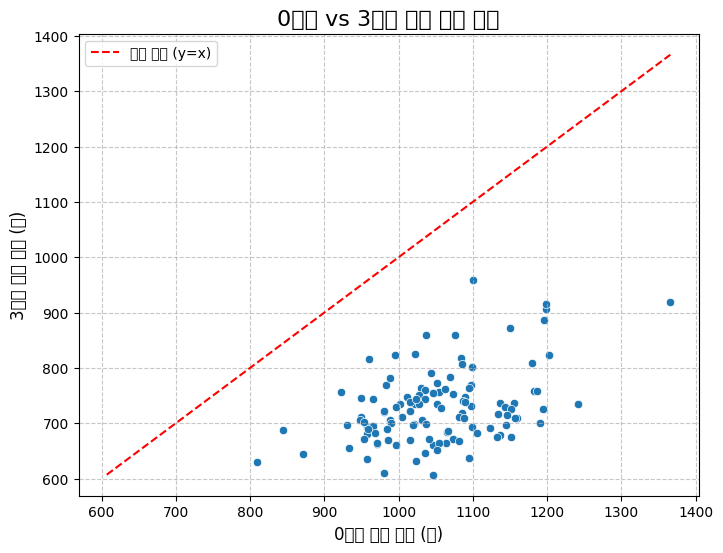

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm # 폰트 깨져서 매니저 불러옴

# 윈도우 환경(맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
# 마이너스 부호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False


plt.figure(figsize=(8, 6)) # 그래프의 크기를 설정 (가로 8인치, 세로 6인치)

# 산점도 그리기
# x축: 0주차에서 특정 레벨까지 충전되는 데 걸리는 시간
# y축: 3주차에서 특정 레벨까지 충전되는 데 걸리는 시간
sns.scatterplot(x='CV_time_0', y='CV_time_3', data=train_df)

# 대각선 (y=x) 추가: 둘의 시간이 같다면 점이 대각선 위에 있을 것입니다.
plt.plot([min(train_df['CV_time_0'].min(), train_df['CV_time_3'].min()),
          max(train_df['CV_time_0'].max(), train_df['CV_time_3'].max())],# X축에 찍을 두 점의 좌표
         [min(train_df['CV_time_0'].min(), train_df['CV_time_3'].min()), # y축에 찍을 두 점의 좌표
          max(train_df['CV_time_0'].max(), train_df['CV_time_3'].max())],
         color='red', linestyle='--', label='변화 없음 (y=x)')

# 그래프 제목과 축 라벨 설정
plt.title('0주차 vs 3주차 충전 시간 비교', fontsize=16)
plt.xlabel('0주차 충전 시간 (분)', fontsize=12)
plt.ylabel('3주차 충전 시간 (분)', fontsize=12)

# 그리드(격자) 추가하여 값 확인 용이하게
plt.grid(True, linestyle='--', alpha=0.7)

# 범례 표시 (대각선 라벨을 보여주기 위해)
plt.legend()

# 그래프 보여주기
plt.show()

In [16]:
# index의 정보를 확인합니다.
train_df.index

Index(['1031U', '1101F', '1138K', '1179M', '1240W', '1303Y', '1397U', '1441V',
       '1454Q', '1513R',
       ...
       '9067Q', '9090C', '9108V', '9349O', '9373N', '9627Y', '9833F', '9835L',
       '9897W', '9908R'],
      dtype='object', name='Cell_ID', length=116)


# ------------------------------------------------------------
불러온 평가용 데이터의 일부를 확인해봅시다.

In [4]:
test_x.head()

,CV_time_0,CV_time_3,Chg_C-rate,Dchg_C-rate,DoD,Q_ini,Q_ini_V_high,Q_ini_V_low,Q_ini_V_mid,Q_initial,...,mean_dqdv_dchg_mid_3_0,min_deltaQ,multi_stress,skew_deltaQ,var_deltaQ,var_deltaQ_dchg_3_0,var_dqdv_dchg_3_0,var_dqdv_dchg_high_3_0,var_dqdv_dchg_low_3_0,var_dqdv_dchg_mid_3_0
Cell_ID,,,,,,,,,,,,,,,,,,,,,
1065Q,1168.0,686.0,1.325,1.825,0.325687,0.282856,-0.088439,-0.078890,-0.116076,0.282856,...,0.036362,-0.014704,0.506454,0.552347,0.000063,0.000063,0.001884,0.004551,0.000617,0.000646
1088R,1021.0,713.0,1.800,0.500,0.976176,0.280780,-0.087853,-0.077446,-0.115675,0.280780,...,0.060289,-0.035938,0.926081,0.236711,0.000259,0.000259,0.003657,0.006232,0.002375,0.002325
1235T,953.0,643.0,2.500,0.500,0.279847,0.283415,-0.091363,-0.076429,-0.115763,0.283415,...,0.033338,-0.022460,0.312878,0.163569,0.000106,0.000106,0.002283,0.003582,0.001981,0.001205
1479K,1145.0,733.0,2.125,1.975,0.530650,0.283360,-0.088303,-0.078583,-0.116972,0.283360,...,0.057076,-0.026895,1.087104,0.593676,0.000145,0.000145,0.002631,0.005570,0.000933,0.001377
1552R,958.0,775.0,1.175,1.425,0.907451,0.283518,-0.092992,-0.075567,-0.115559,0.283518,...,0.060685,-0.023440,1.174220,0.735341,0.000097,0.000097,0.001953,0.004097,0.000276,0.000441


In [5]:
print("Train Data 크기 :", train_df.shape)
print("Test Data 크기 :", test_x.shape)

Train Data 크기 : (116, 35)
Test Data 크기 : (109, 34)


## 데이터 전처리

1. 결측치가 있는지 확인합니다.

In [ ]:
na_columns_train = train_x.columns[train_x.isna().any()]
na_columns_test = test_x.columns[test_x.isna().any()]
na_columns = set(na_columns_train) | set(na_columns_test)
na_columns

2. 데이터를 정규화 합니다.

In [ ]:
# 데이터 정규화

scaler = MinMaxScaler()
train_x_scaled = scaler.fit_transform(train_x)
test_x_scaled = scaler.transform(test_x)

In [ ]:
print("Train Data 크기 :", train_x.shape)
print("Test Data 크기 :", test_x.shape)

## 모델 학습

모델은 각자 자유롭게 구성할 수 있으며, 올바른 형식으로 `submission.csv`를 작성한다면 다양한 모델이 허용됩니다.

아래는 이해를 돕기 위한 예시 코드로, 간단한 서포트 벡터 머신 기반 회귀 예측 모델 (SVR) 을 사용합니다.

In [ ]:
model = SVR()
model.fit(train_x, train_y)

학습 데이터에 대한 성능을 확인합니다.

In [ ]:
pred_train = model.predict(train_x)
print("MAPE Score for Train: ", mean_absolute_percentage_error(train_y, pred_train))

## 모델 평가 및 결과 저장

회귀 모델을 평가하기 위한 지표는 다양하게 있으며, 저희는 그 중에서 **MAPE Score** 지표를 활용하여 순위를 결정할 것입니다.

여러분들이 작성하신 모델의 성능을 평가하기 위해서는, 지시사항에 나와 있는 대로 **테스트 데이터**를 불러와서 예측을 수행하고, 그 결과를 반드시 `submission.csv` 파일에 기록하여 제출해야 합니다.

In [ ]:
# 제출 템플릿을 불러옵니다.
submission = pd.read_csv("submission.csv", index_col=0)

# 테스트 데이터에 대한 예측 결과를 저장합니다.
# Note. 예시 코드에서는 index(Cell_ID)의 순서를 수정하지 않아서 예측 결과를 바로 템플릿에 할당했지만, 
# 만약 학습 과정에서 index를 수정하셨다면, sort_index() 등으로 index를 맞추는 것을 권장 드립니다.
submission["Lifetime"] = model.predict(test_x)
submission.to_csv("submission.csv")

### 결과 검증

`submission.csv` 파일을 다시 불러와 올바르게 값을 채웠는지 다시 한번 확인합니다.

In [ ]:
submission = pd.read_csv("submission.csv", index_col=0)
submission

### 제출

`submission.csv` 파일이 제대로 생성됐다면, 우측 상단의 제출 버튼을 눌러 `submission.csv` 파일을 제출하고 리더보드에서 점수를 확인하세요.

- 팀당 제출 가능 횟수는 **1일 20회** 입니다. 팀 내 모든 구성원이 제출 가능하나 팀 제출 횟수는 팀 단위로 합산됩니다.
- 최종 채점 기준: Private score 50% + Public score 50%
- 리더보드에는 **마지막으로 제출한 결과**의 Public 점수가 공개됩니다.
- 최종 채점에는 마지막으로 제출된 결과로 평가됩니다.

## 경진대회 종료 전 제출을 희망하는 코드와 결과물로 마지막 제출을 수행하세요.
## 반드시 마지막 제출된 프로젝트의 전체 파일을 압축하여 별도의 제출 공간에 제출하세요.

다음 파일들을 압축하여 별도의 제출공간에 제출해야 합니다.
- `code.ipynb`: 전체 프로젝트 진행 파일
- `submission.csv`: 예측 결과 파일
- 외부 데이터 사용 시: 원본 데이터 파일(혹은 데이터 다운로드 코드)
    - 외부 데이터에 대한 전처리 과정은 프로젝트 코드 내에 포함되어야 함
- 기타 프로젝트 실행에 필요한 모든 파일